In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import matplotlib.pyplot as plt


Using TensorFlow backend.


## Load data and preprocessing

In [189]:
veg_class = ['香蕉','洋香瓜-網狀紅肉','蓮霧-紅蓮霧','鳳梨-金鑽鳳梨','南瓜-木瓜形',
             '大蒜-蒜仁','青蔥-日蔥','小白菜-土白菜','芽菜類-黃豆牙','木瓜-網室紅肉']

Number = ['C0A530','467490','467420','467440','C0C590',
          'C0D560','C0E750','C0H950','C0G660','C0K240',
          '467480','467590','467080','C0Z061','467660']

station = ['Pinglin','Taichung','Yongkang','Kaohsiung','Guanyin',
           'Zhudong','Miaoli','Zhongliao','Xihu','Caoling',
           'Chiayi','Hengchung','Yilan','Yuli','Taitung']

city = ['NewTaipeiCity','TaichungCity','TainanCity','KaohsiungCity','TaoyuanCity',
        'HsinchuCounty','MiaoliCounty','NantouCounty','ChanghuaCounty','YunlinCounty',
        'ChiayiCity','PingtungCounty','YilanCounty','HualienCounty','TaitungCounty']

WeatherColumns = ['StnPres','Temperature','WS','WSGust','Precp']

In [186]:
# Change Parameters
idx = 0
now_target = "3_day_return"
now_target_pred = now_target + "_pred"
drop_target = "Price"

veg_name = veg_class[idx]
train_cut_head=[0,0,0,0,0,0,0,17,0,0]
train_cut_tail=[2111,2093,2110,2111,2112,2112,2111,2123,2108,2111]

In [187]:
now_target, now_target_pred, drop_target

('3_day_return', '3_day_return_pred', 'Price')

In [188]:
all_df = pd.read_csv("all_info_utf8.csv")

In [190]:
def readTrain():
    grouped_df = all_df.groupby(all_df.作物名稱)
    veg = grouped_df.get_group(veg_name)
    market_df = veg.groupby(veg.市場名稱)
    market = market_df.get_group('台北一')
    market = market.rename(columns = {'平均價': 'Price', '交易量': 'Trading_volume','強度':'Typhoon_strength','警報發布報數':'Warning_freq'}, inplace = False)
    market = market.drop(columns=['作物代號', '作物名稱', '市場代號', '市場名稱', drop_target, '1_day_return', '5_day_return', 'DateTime'])
    #market = market.rename(columns = {'交易量': 'Trading_volume','強度':'Typhoon_strength','警報發布報數':'Warning_freq'}, inplace = False)
    return market

In [191]:
# Normalize all attribute
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm

In [192]:
# Denormalize test and predict value
def de_normalize(test,y_max,y_min,y_mean):
    test_denorm = test.apply(lambda y: y * (y_max - y_min) + y_mean)
    return test_denorm

In [193]:
# Build training set
def buildTrain(train, pastDay=30, futureDay=5):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay][now_target]))
    return np.array(X_train), np.array(Y_train)

In [194]:
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [195]:
def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val


In [196]:
dataset =  readTrain()

In [197]:
dataset[train_cut_head[idx]:train_cut_tail[idx]]

,Year,Month,Day,3_day_return,Trading_volume,Typhoon_strength,Warning_freq,C0A530_StnPres,C0A530_Temperature,C0A530_WS,...,C0Z061_StnPres,C0Z061_Temperature,C0Z061_WS,C0Z061_WSGust,C0Z061_Precp,467660_StnPres,467660_Temperature,467660_WS,467660_WSGust,467660_Precp
12024,2012.0,1.0,1.0,0.000000,21521.0,0.0,0.0,988.0,11.5,1.4,...,1004.9,14.7,0.6,5.6,2.0,1019.6,18.4,1.6,9.4,0.0
12025,2012.0,1.0,3.0,0.000000,14700.0,0.0,0.0,985.7,12.5,2.1,...,1002.6,16.9,0.6,7.7,0.0,1017.9,19.5,1.6,6.6,0.0
12026,2012.0,1.0,4.0,0.000000,19953.0,0.0,0.0,990.9,7.3,1.6,...,1007.2,13.0,1.4,7.8,0.5,1021.8,17.1,2.5,13.2,0.0
12027,2012.0,1.0,5.0,3.296703,18523.0,0.0,0.0,988.5,9.3,1.2,...,1006.7,12.5,0.4,4.4,0.5,1021.6,15.2,1.5,6.7,0.4
12028,2012.0,1.0,6.0,5.978261,22340.0,0.0,0.0,987.0,13.1,0.7,...,1004.0,15.5,0.4,4.4,2.0,1019.2,18.4,1.3,6.3,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14130,2018.0,12.0,26.0,-11.036789,19066.0,0.0,0.0,980.1,18.3,0.5,...,996.1,21.5,0.5,4.0,4.5,1010.8,23.7,1.9,9.8,0.0
14131,2018.0,12.0,27.0,-3.900709,15444.0,0.0,0.0,984.7,14.8,1.3,...,1000.5,18.4,0.6,4.8,1.0,1014.4,21.9,2.2,12.9,0.0
14132,2018.0,12.0,28.0,-1.090909,14306.0,0.0,0.0,990.7,11.8,2.5,...,1006.8,16.7,1.3,7.2,0.0,1020.4,20.1,2.5,13.7,0.0
14133,2018.0,12.0,29.0,4.511278,16381.0,0.0,0.0,994.2,10.5,2.6,...,1010.7,15.2,1.3,8.0,0.0,1024.9,17.9,2.6,16.8,0.0


In [198]:
for i, col in enumerate(dataset.columns):
    for j, num in enumerate(Number):
        if Number[j] in col:
            print(col, col.replace(Number[j], city[j]))
            dataset = dataset.rename(columns = {col: col.replace(Number[j], city[j])})

C0A530_StnPres NewTaipeiCity_StnPres
C0A530_Temperature NewTaipeiCity_Temperature
C0A530_WS NewTaipeiCity_WS
C0A530_WSGust NewTaipeiCity_WSGust
C0A530_Precp NewTaipeiCity_Precp
467490_StnPres TaichungCity_StnPres
467490_Temperature TaichungCity_Temperature
467490_WS TaichungCity_WS
467490_WSGust TaichungCity_WSGust
467490_Precp TaichungCity_Precp
467420_StnPres TainanCity_StnPres
467420_Temperature TainanCity_Temperature
467420_WS TainanCity_WS
467420_WSGust TainanCity_WSGust
467420_Precp TainanCity_Precp
467440_StnPres KaohsiungCity_StnPres
467440_Temperature KaohsiungCity_Temperature
467440_WS KaohsiungCity_WS
467440_WSGust KaohsiungCity_WSGust
467440_Precp KaohsiungCity_Precp
C0C590_StnPres TaoyuanCity_StnPres
C0C590_Temperature TaoyuanCity_Temperature
C0C590_WS TaoyuanCity_WS
C0C590_WSGust TaoyuanCity_WSGust
C0C590_Precp TaoyuanCity_Precp
C0D560_StnPres HsinchuCounty_StnPres
C0D560_Temperature HsinchuCounty_Temperature
C0D560_WS HsinchuCounty_WS
C0D560_WSGust HsinchuCounty_WSGust
C

## many to one model

In [199]:
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # output shape: (1, 1)
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

### Training (2012~2018): past 7 day to predict next 1 day

In [200]:
train = dataset[train_cut_head[idx]:train_cut_tail[idx]]

train_norm = normalize(train)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 7, 1)
X_train, Y_train = shuffle(X_train, Y_train)
# because no return sequence, Y_train and Y_val shape must be 2 dimension
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

loss = history.history['loss']
epochs = range(len(loss))

The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(7, 82))`


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                3720      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 3,731
Trainable params: 3,731
Non-trainable params: 0
_________________________________________________________________
Train on 1893 samples, validate on 210 samples
Epoch 1/1000
1893/1893 [==============================] - 1s 293us/step - loss: 0.0190 - val_loss: 0.0191
Epoch 2/1000
1893/1893 [==============================] - 0s 101us/step - loss: 0.0157 - val_loss: 0.0182
Epoch 3/1000
1893/1893 [==============================] - 0s 99us/step - loss: 0.0146 - val_loss: 0.0176
Epoch 4/1000
1893/1893 [==============================] - 0s 96us/step - loss: 0.0141 - val_loss: 0.0172
Epoch 5/1000
1893/1893 [=====================

1893/1893 [==============================] - 0s 95us/step - loss: 0.0044 - val_loss: 0.0069
Epoch 72/1000
1893/1893 [==============================] - 0s 96us/step - loss: 0.0044 - val_loss: 0.0070
Epoch 73/1000
1893/1893 [==============================] - 0s 97us/step - loss: 0.0044 - val_loss: 0.0069
Epoch 74/1000
1893/1893 [==============================] - 0s 95us/step - loss: 0.0044 - val_loss: 0.0069
Epoch 75/1000
1893/1893 [==============================] - 0s 92us/step - loss: 0.0043 - val_loss: 0.0070
Epoch 76/1000
1893/1893 [==============================] - 0s 93us/step - loss: 0.0043 - val_loss: 0.0069
Epoch 77/1000
1893/1893 [==============================] - 0s 113us/step - loss: 0.0043 - val_loss: 0.0070
Epoch 78/1000
1893/1893 [==============================] - 0s 102us/step - loss: 0.0043 - val_loss: 0.0069
Epoch 79/1000
1893/1893 [==============================] - 0s 99us/step - loss: 0.0042 - val_loss: 0.0069
Epoch 80/1000
1893/1893 [==============================] -

1893/1893 [==============================] - 0s 114us/step - loss: 0.0033 - val_loss: 0.0074
Epoch 148/1000
1893/1893 [==============================] - 0s 111us/step - loss: 0.0034 - val_loss: 0.0072
Epoch 149/1000
1893/1893 [==============================] - 0s 100us/step - loss: 0.0034 - val_loss: 0.0073
Epoch 150/1000
1893/1893 [==============================] - 0s 95us/step - loss: 0.0033 - val_loss: 0.0073
Epoch 151/1000
1893/1893 [==============================] - 0s 101us/step - loss: 0.0034 - val_loss: 0.0074
Epoch 152/1000
1893/1893 [==============================] - 0s 115us/step - loss: 0.0033 - val_loss: 0.0072
Epoch 153/1000
1893/1893 [==============================] - 0s 109us/step - loss: 0.0033 - val_loss: 0.0072
Epoch 154/1000
1893/1893 [==============================] - 0s 102us/step - loss: 0.0033 - val_loss: 0.0073
Epoch 155/1000
1893/1893 [==============================] - 0s 99us/step - loss: 0.0033 - val_loss: 0.0072
Epoch 156/1000
1893/1893 [===================

Epoch 223/1000
1893/1893 [==============================] - 0s 100us/step - loss: 0.0026 - val_loss: 0.0079
Epoch 224/1000
1893/1893 [==============================] - 0s 99us/step - loss: 0.0026 - val_loss: 0.0079
Epoch 225/1000
1893/1893 [==============================] - 0s 98us/step - loss: 0.0026 - val_loss: 0.0078
Epoch 226/1000
1893/1893 [==============================] - 0s 122us/step - loss: 0.0026 - val_loss: 0.0078
Epoch 227/1000
1893/1893 [==============================] - 0s 135us/step - loss: 0.0026 - val_loss: 0.0079
Epoch 228/1000
1893/1893 [==============================] - 0s 107us/step - loss: 0.0026 - val_loss: 0.0079
Epoch 229/1000
1893/1893 [==============================] - 0s 118us/step - loss: 0.0026 - val_loss: 0.0080
Epoch 230/1000
1893/1893 [==============================] - 0s 109us/step - loss: 0.0026 - val_loss: 0.0079
Epoch 231/1000
1893/1893 [==============================] - 0s 125us/step - loss: 0.0026 - val_loss: 0.0078
Epoch 232/1000
1893/1893 [====

1893/1893 [==============================] - 0s 101us/step - loss: 0.0021 - val_loss: 0.0088
Epoch 299/1000
1893/1893 [==============================] - 0s 97us/step - loss: 0.0021 - val_loss: 0.0089
Epoch 300/1000
1893/1893 [==============================] - 0s 98us/step - loss: 0.0021 - val_loss: 0.0088
Epoch 301/1000
1893/1893 [==============================] - 0s 103us/step - loss: 0.0021 - val_loss: 0.0090
Epoch 302/1000
1893/1893 [==============================] - 0s 115us/step - loss: 0.0021 - val_loss: 0.0089
Epoch 303/1000
1893/1893 [==============================] - 0s 97us/step - loss: 0.0021 - val_loss: 0.0090
Epoch 304/1000
1893/1893 [==============================] - 0s 113us/step - loss: 0.0021 - val_loss: 0.0090
Epoch 305/1000
1893/1893 [==============================] - 0s 108us/step - loss: 0.0021 - val_loss: 0.0089
Epoch 306/1000
1893/1893 [==============================] - 0s 117us/step - loss: 0.0021 - val_loss: 0.0090
Epoch 307/1000
1893/1893 [====================

1893/1893 [==============================] - 0s 94us/step - loss: 0.0018 - val_loss: 0.0101
Epoch 375/1000
1893/1893 [==============================] - 0s 94us/step - loss: 0.0018 - val_loss: 0.0101
Epoch 376/1000
1893/1893 [==============================] - 0s 88us/step - loss: 0.0018 - val_loss: 0.0101
Epoch 377/1000
1893/1893 [==============================] - 0s 94us/step - loss: 0.0017 - val_loss: 0.0101
Epoch 378/1000
1893/1893 [==============================] - 0s 89us/step - loss: 0.0017 - val_loss: 0.0100
Epoch 379/1000
1893/1893 [==============================] - 0s 91us/step - loss: 0.0017 - val_loss: 0.0102
Epoch 380/1000
1893/1893 [==============================] - 0s 95us/step - loss: 0.0017 - val_loss: 0.0102
Epoch 381/1000
1893/1893 [==============================] - 0s 94us/step - loss: 0.0017 - val_loss: 0.0101
Epoch 382/1000
1893/1893 [==============================] - 0s 95us/step - loss: 0.0017 - val_loss: 0.0101
Epoch 383/1000
1893/1893 [==========================

1893/1893 [==============================] - 0s 96us/step - loss: 0.0014 - val_loss: 0.0110
Epoch 451/1000
1893/1893 [==============================] - 0s 91us/step - loss: 0.0014 - val_loss: 0.0112
Epoch 452/1000
1893/1893 [==============================] - 0s 106us/step - loss: 0.0014 - val_loss: 0.0112
Epoch 453/1000
1893/1893 [==============================] - 0s 94us/step - loss: 0.0014 - val_loss: 0.0110
Epoch 454/1000
1893/1893 [==============================] - 0s 97us/step - loss: 0.0014 - val_loss: 0.0112
Epoch 455/1000
1893/1893 [==============================] - 0s 104us/step - loss: 0.0014 - val_loss: 0.0111
Epoch 456/1000
1893/1893 [==============================] - 0s 98us/step - loss: 0.0014 - val_loss: 0.0112
Epoch 457/1000
1893/1893 [==============================] - 0s 98us/step - loss: 0.0014 - val_loss: 0.0112
Epoch 458/1000
1893/1893 [==============================] - 0s 89us/step - loss: 0.0014 - val_loss: 0.0111
Epoch 459/1000
1893/1893 [========================

1893/1893 [==============================] - 0s 105us/step - loss: 0.0012 - val_loss: 0.0119
Epoch 527/1000
1893/1893 [==============================] - 0s 96us/step - loss: 0.0012 - val_loss: 0.0118
Epoch 528/1000
1893/1893 [==============================] - 0s 110us/step - loss: 0.0012 - val_loss: 0.0118
Epoch 529/1000
1893/1893 [==============================] - 0s 97us/step - loss: 0.0012 - val_loss: 0.0120
Epoch 530/1000
1893/1893 [==============================] - 0s 96us/step - loss: 0.0012 - val_loss: 0.0120
Epoch 531/1000
1893/1893 [==============================] - 0s 92us/step - loss: 0.0012 - val_loss: 0.0118
Epoch 532/1000
1893/1893 [==============================] - 0s 96us/step - loss: 0.0012 - val_loss: 0.0119
Epoch 533/1000
1893/1893 [==============================] - 0s 97us/step - loss: 0.0012 - val_loss: 0.0119
Epoch 534/1000
1893/1893 [==============================] - 0s 96us/step - loss: 0.0012 - val_loss: 0.0119
Epoch 535/1000
1893/1893 [========================

In [201]:
X_train.shape

(1893, 7, 82)

In [202]:
Y_train.shape

(1893, 1)

### Testing (2019)

In [203]:
test = dataset[train_cut_tail[idx]-7:]

In [204]:
test.head(10)

,Year,Month,Day,3_day_return,Trading_volume,Typhoon_strength,Warning_freq,NewTaipeiCity_StnPres,NewTaipeiCity_Temperature,NewTaipeiCity_WS,...,HualienCounty_StnPres,HualienCounty_Temperature,HualienCounty_WS,HualienCounty_WSGust,HualienCounty_Precp,TaitungCounty_StnPres,TaitungCounty_Temperature,TaitungCounty_WS,TaitungCounty_WSGust,TaitungCounty_Precp
14128,2018.0,12.0,23.0,-12.693498,19338.0,0.0,0.0,985.3,18.0,1.8,...,1001.9,20.3,0.7,5.9,15.0,1016.1,22.5,1.4,8.7,41.1
14129,2018.0,12.0,25.0,-14.596273,20056.0,0.0,0.0,981.4,19.3,1.2,...,999.2,19.9,0.2,2.8,0.5,1013.3,22.1,1.5,6.6,0.7
14130,2018.0,12.0,26.0,-11.036789,19066.0,0.0,0.0,980.1,18.3,0.5,...,996.1,21.5,0.5,4.0,4.5,1010.8,23.7,1.9,9.8,0.0
14131,2018.0,12.0,27.0,-3.900709,15444.0,0.0,0.0,984.7,14.8,1.3,...,1000.5,18.4,0.6,4.8,1.0,1014.4,21.9,2.2,12.9,0.0
14132,2018.0,12.0,28.0,-1.090909,14306.0,0.0,0.0,990.7,11.8,2.5,...,1006.8,16.7,1.3,7.2,0.0,1020.4,20.1,2.5,13.7,0.0
14133,2018.0,12.0,29.0,4.511278,16381.0,0.0,0.0,994.2,10.5,2.6,...,1010.7,15.2,1.3,8.0,0.0,1024.9,17.9,2.6,16.8,0.0
14134,2018.0,12.0,30.0,-0.738007,16236.0,0.0,0.0,992.5,12.6,2.5,...,1010.0,16.6,1.2,7.1,0.0,1024.3,19.0,2.5,14.3,0.0
14135,2019.0,1.0,1.0,-2.941176,20807.0,0.0,0.0,993.3,14.2,2.3,...,1010.0,17.8,1.2,7.0,0.5,1023.9,20.8,2.1,13.7,0.0
14136,2019.0,1.0,2.0,-5.395683,15808.0,0.0,0.0,992.1,14.9,2.2,...,1009.5,17.2,0.7,5.5,6.0,1023.7,19.1,1.1,6.8,3.5
14137,2019.0,1.0,3.0,1.486989,17444.0,0.0,0.0,991.8,16.6,1.7,...,1008.9,18.9,0.6,6.4,0.5,1023.2,21.6,1.3,9.3,0.0


In [205]:
# Remember max min mean in order to do denormalize
y_max = np.max(test[now_target])
y_min = np.min(test[now_target])
y_mean = np.mean(test[now_target])

In [206]:
test_norm = normalize(test)

In [207]:
X_test, y_test = buildTrain(test_norm, 7, 1)

In [208]:
# Predict the model
y_pred = model.predict(X_test)

Glyph 39321 missing from current font.
Glyph 34121 missing from current font.
Glyph 39321 missing from current font.
Glyph 34121 missing from current font.


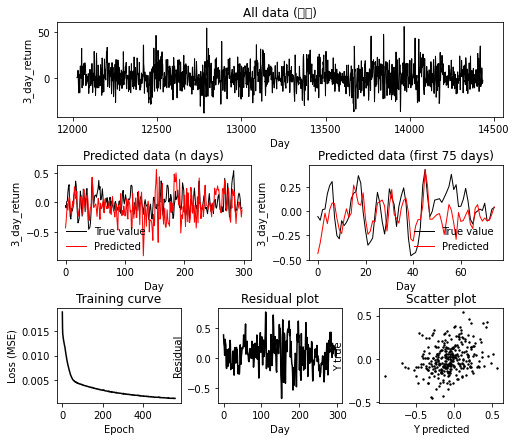

mse=0.059
r2=-1.2


In [209]:
# plot the result

plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset[now_target], color='black', linewidth=1, label='True value')
plt.ylabel(now_target)
plt.xlabel("Day")
plt.title("All data (" + veg_name + ")")

plt.subplot(3, 2, 3)
plt.plot(y_test, color='black', linewidth=1, label='True value')
plt.plot(y_pred, color='red', linewidth=1, label='Predicted')
plt.legend(frameon=False)
plt.ylabel(now_target)
plt.xlabel("Day")
plt.title("Predicted data (n days)")

# 畫出前 75 天的預測
plt.subplot(3, 2, 4)
plt.plot(y_test[0:75], color='black', linewidth=1, label='True value')
plt.plot(y_pred[0:75], color='red', linewidth=1, label='Predicted')
plt.legend(frameon=False)
plt.ylabel(now_target)
plt.xlabel("Day")
plt.title("Predicted data (first 75 days)")

# 訓練曲線，殘插圖，散點圖
plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test - y_pred, color='black')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_pred, y_test, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("mse=" + str(round(mse,3)))
print("r2=" + str(round(r2,3)))

In [210]:
# Denormalize the truth value
y_test_df = pd.DataFrame(y_test)
y_test_denorm = de_normalize(y_test_df,y_max,y_min,y_mean)

In [211]:
# Denormalize the predict value
y_pred_df = pd.DataFrame(y_pred)
y_pred_denorm = de_normalize(y_pred_df,y_max,y_min,y_mean)

In [212]:
y_test_denorm

,0
0,-2.941176
1,-5.395683
2,1.486989
3,1.893939
4,11.787072
...,...
293,8.750000
294,4.294479
295,-5.949008
296,-6.321839


In [213]:
y_pred_denorm

,0
0,-26.872801
1,-19.970438
2,-10.435650
3,-0.793558
4,-7.572129
...,...
293,-0.490930
294,-6.326653
295,-7.431158
296,-15.194056


In [214]:
mean_squared_error(y_test, y_pred)

0.05929009542993337

In [215]:
output = pd.concat([y_test_denorm,y_pred_denorm],axis=1)
output.columns = [now_target,now_target_pred]

In [216]:
Date = test[7:-1][["Year","Month","Day"]].reset_index()
Date = Date.astype({"Year": int, "Month": int, "Day": int})

In [217]:
output['date'] = Date[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1)
output['date'] = pd.to_datetime(output['date'])
output = output[['date',now_target,now_target_pred]]

In [218]:
output

,date,3_day_return,3_day_return_pred
0,2019-01-01,-2.941176,-26.872801
1,2019-01-02,-5.395683,-19.970438
2,2019-01-03,1.486989,-10.435650
3,2019-01-04,1.893939,-0.793558
4,2019-01-05,11.787072,-7.572129
...,...,...,...
293,2019-12-25,8.750000,-0.490930
294,2019-12-26,4.294479,-6.326653
295,2019-12-27,-5.949008,-7.431158
296,2019-12-28,-6.321839,-15.194056


In [351]:
output.to_csv('./Outputs/2019_台北一_'+veg_name+'_'+now_target+'.csv', index=False)

In [120]:
for weight in model.get_weights(): # weights from Dense layer omitted
    print(weight.shape)

(82, 40)
(10, 40)
(40,)
(10, 1)
(1,)


In [219]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
explainer = shap.DeepExplainer(model, X_train)

# explain the first 10 predictions
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(X_test)

In [220]:
# init the JS visualization code
shap.initjs()

shap.force_plot(explainer.expected_value[0], shap_values[0][:,0,:], test)
#shap.summary_plot(explainer.expected_value[0], shap_values[0][0],feature_names=train,max_display=10,plot_type='bar')

In [221]:
shap_values[0][:,0,:].shape

(298, 82)

In [222]:
test[8:].shape

(298, 82)

In [223]:
day_mean = np.zeros((298, 82))
for i in range(7):
    day_mean += shap_values[0][:,i,:]
day_mean = day_mean/7.0

In [224]:
day = 0
shap.force_plot(explainer.expected_value[0], day_mean[day,:], test.iloc[day+7,:])

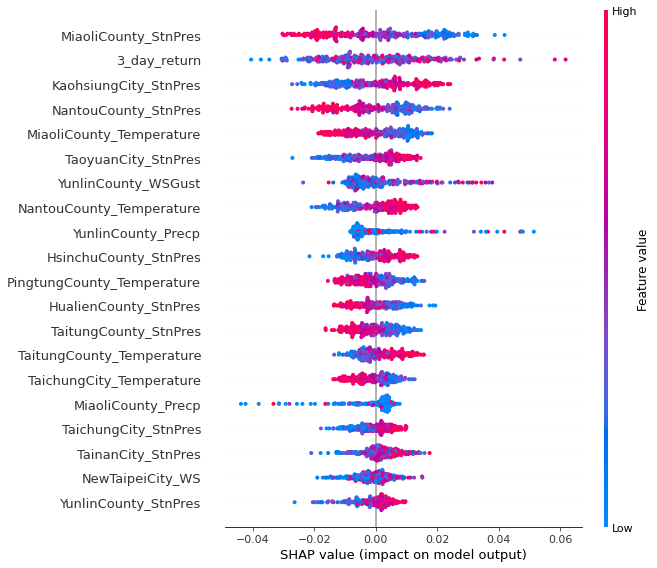

In [225]:
# summarize the effects of all the features
shap.summary_plot(day_mean, test[8:])

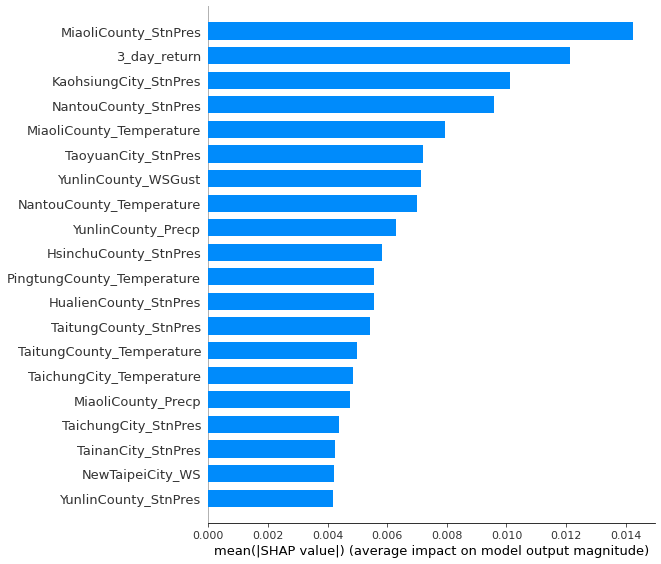

In [226]:
shap.summary_plot(day_mean, test[8:], plot_type="bar")

In [179]:
importance=[]
abs_importance=[]
for i in range(82):
    tmp = 0
    for j in range(298):
        tmp += day_mean[j][i]
    importance.append(round(tmp/298*1000,4))
    abs_importance.append(np.abs(round(tmp/298*1000,4)))

In [180]:
for i in range(82):
    print(test.columns[i],importance[i],abs_importance[i])

Year 0.2279 0.2279
Month -0.062 0.062
Day 0.2518 0.2518
Price -1.1416 1.1416
Trading_volume -0.0487 0.0487
Typhoon_strength -0.0827 0.0827
Warning_freq 0.0877 0.0877
NewTaipeiCity_StnPres 0.2589 0.2589
NewTaipeiCity_Temperature -0.1579 0.1579
NewTaipeiCity_WS -0.8872 0.8872
NewTaipeiCity_WSGust -0.7228 0.7228
NewTaipeiCity_Precp 0.0142 0.0142
TaichungCity_StnPres 0.239 0.239
TaichungCity_Temperature -0.3379 0.3379
TaichungCity_WS -0.0173 0.0173
TaichungCity_WSGust -0.3827 0.3827
TaichungCity_Precp -0.0003 0.0003
TainanCity_StnPres -0.6997 0.6997
TainanCity_Temperature -0.269 0.269
TainanCity_WS -0.0015 0.0015
TainanCity_WSGust -0.0335 0.0335
TainanCity_Precp -0.1159 0.1159
KaohsiungCity_StnPres 0.2612 0.2612
KaohsiungCity_Temperature -0.7307 0.7307
KaohsiungCity_WS 0.0647 0.0647
KaohsiungCity_WSGust -0.3025 0.3025
KaohsiungCity_Precp -0.4611 0.4611
TaoyuanCity_StnPres 0.6758 0.6758
TaoyuanCity_Temperature -0.3224 0.3224
TaoyuanCity_WS -0.0461 0.0461
TaoyuanCity_WSGust 0.0303 0.0303
Tao

In [181]:
feature_importance = pd.DataFrame(list(zip(test.columns, importance, abs_importance)), columns =['Features', 'Importance','abs_Importance']) 

In [185]:
feature_importance.sort_values(by=['abs_Importance'], ascending=False).head(10)

,Features,Importance,abs_Importance
49,ChanghuaCounty_WS,-1.1863,1.1863
72,HualienCounty_StnPres,-1.1850,1.1850
3,Price,-1.1416,1.1416
9,NewTaipeiCity_WS,-0.8872,0.8872
48,ChanghuaCounty_Temperature,0.8049,0.8049
40,MiaoliCounty_WSGust,-0.7667,0.7667
23,KaohsiungCity_Temperature,-0.7307,0.7307
10,NewTaipeiCity_WSGust,-0.7228,0.7228
17,TainanCity_StnPres,-0.6997,0.6997
68,YilanCounty_Temperature,-0.6843,0.6843
